In [55]:
from tensorflow import keras
model = keras.models.load_model("3-conv-32-layer-1-dense.model_00h")
model.summary()

Model: "my_functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 30, 12)]      0         
                                                                 
 sequential (Sequential)     (None, 30, 30, 12)        0         
                                                                 
 my_conv2d_1 (Conv2D)        (None, 28, 28, 32)        3488      
                                                                 
 my_pooling_1 (MaxPooling2D)  (None, 14, 14, 32)       0         
                                                                 
 my_conv2d_2 (Conv2D)        (None, 12, 12, 64)        18496     
                                                                 
 my_pooling_2 (MaxPooling2D)  (None, 6, 6, 64)         0         
                                                                 
 my_conv2d_3 (Conv2D)        (None, 4, 4, 128) 

In [56]:
#
# Function to return input data as an numpy array
#
def prepare(filepath):
    IMG_SIZE = 30
    number_channels = 12
    f = netCDF4.Dataset(filepath)
    abv = f.variables['absvprs']
    nx = np.size(abv[0,0,:])
    ny = np.size(abv[0,:,0])
    nz = np.size(abv[:,0,0])
    #print('Dimension of input NETCDF is: ',nx,ny,nz)
    a2 = np.zeros((nx,ny,number_channels))
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,0] = abv[1,j,i]    # abs vort at 950 mb
    rel = f.variables['rhprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,1] = rel[7,j,i]    # RH at 750 mb
    sfc = f.variables['pressfc']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,2] = sfc[j,i]      # surface pressure
    tmp = f.variables['tmpprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,3] = tmp[15,j,i]   # temperature at 400 mb
    tsf = f.variables['tmpsfc']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,4] = tsf[j,i]      # surface temperature
    ugr = f.variables['ugrdprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,5] = ugr[3,j,i]    # u-wind at 900 mb
            a2[i,j,6] = ugr[17,j,i]   # u-wind at 300 mb
    vgr = f.variables['vgrdprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,7] = vgr[3,j,i]    # v-wind at 900 mb
            a2[i,j,8] = vgr[17,j,i]   # v-wind at 300 mb
    hgt = f.variables['hgtprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,9] = hgt[3,j,i]    # geopotential at 850 mb
    wgr = f.variables['vvelprs']
    for i in range(a2.shape[0]):
        for j in range(a2.shape[1]):
            a2[i,j,10] = wgr[3,j,i]   # w-wind at 900 mb
            a2[i,j,11] = wgr[17,j,i]  # w-wind at 300 mb
    new_array = cv2.resize(a2, (IMG_SIZE, IMG_SIZE))
    dim_array = cv2.resize(a2, (IMG_SIZE, IMG_SIZE))
    #
    # normalize the data
    #
    #print('Number of channels to normalize is: ',number_channels)
    for var in range(number_channels):
        maxvalue = new_array[:,:,var].flat[np.abs(new_array[:,:,var]).argmax()]
        #print('Normalization factor for channel',var,', is: ',abs(maxvalue))
        new_array[:,:,var] = new_array[:,:,var]/abs(maxvalue)
    out_array = np.reshape(new_array, (-1, IMG_SIZE, IMG_SIZE, number_channels))
    #print('reshape new_array returns: ',out_array.shape)
    #input('Enter to continue...')
    return out_array,dim_array

In [57]:
#
# reading a sample input file for visualizing the activation map 
#
import cv2
import tensorflow as tf
import os
from tqdm import tqdm
import netCDF4
import numpy as np
DATADIR = "/N/project/hurricane-deep-learning/data/ncep_extracted_binary_30x30/ncep_WP_binary_0h/pos/"
#infile = DATADIR + '/20210715_18_00_16.6_135.1_2021197N17135.nc'
infile = DATADIR + '/20170714_00_00_16.0_114.1_2017195N16114.nc'
print("File to process is: ",infile)
indata,dim_data = prepare(infile)
print("Input data shape is: ",indata.shape)
preds = model.predict(indata)
#print(dir(preds))
print(preds.max(),preds.shape)
np.argmax(preds[0])

File to process is:  /N/project/hurricane-deep-learning/data/ncep_extracted_binary_30x30/ncep_WP_binary_0h/pos//20170714_00_00_16.0_114.1_2017195N16114.nc
Input data shape is:  (1, 30, 30, 12)
1/1 [==============================] - 0s 42ms/step
0.9998676 (1, 1)


0

In [58]:
#
# set up a model that returns the last conv layer
#
from tensorflow.keras import layers
last_conv_layer_name = "my_conv2d_3"
classifier_layer_names = ["my_pooling_3", "my_flatten", "dropout_2", "dense", "my_dense"]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
#print(dir(last_conv_layer_model))
print(last_conv_layer.output.shape[1:])

(4, 4, 128)


In [59]:
#
# Apply the classifier on top of the last convolutional output
#
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    print(layer_name)
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input,x)

my_pooling_3
my_flatten
dropout_2
dense
my_dense


In [60]:
#
# retrieving gradient of the top predicted class
#
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(indata)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:,top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)
print(grads.shape)

(1, 4, 4, 128)


In [61]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()
print(pooled_grads.shape)
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:,:,i] *= pooled_grads[i]

heatmap = np.mean(last_conv_layer_output, axis=-1)

(128,)


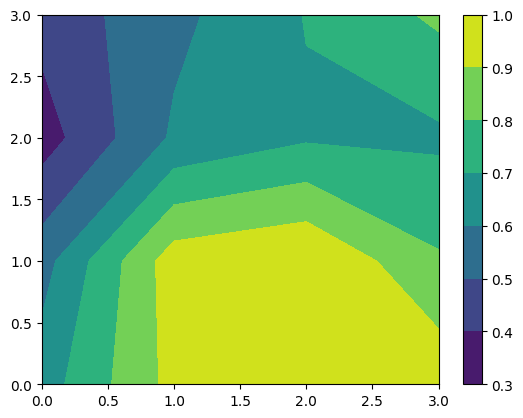

In [62]:
#
# plotting heatmap activation only
#
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.contourf(heatmap) 
plt.colorbar()
a = heatmap.copy()

(1, 30, 30, 12) (4, 4) (30, 30)


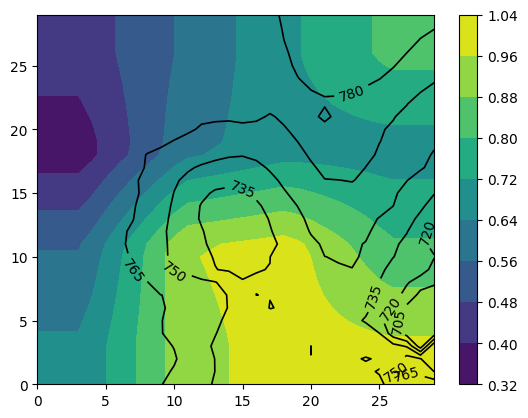

In [65]:
#
# superimposed heatmap on one particular channel
#
print(indata.shape,a.shape,(indata.shape[2],indata.shape[1]))
b=cv2.resize(a,(indata.shape[2],indata.shape[1]))
x=plt.contourf(b) 
plt.colorbar(x)
y=plt.contour(dim_data[:,:,9],colors='k', linewidths=1.2)
plt.clabel(y, inline=1, fontsize=10)
plt.show()

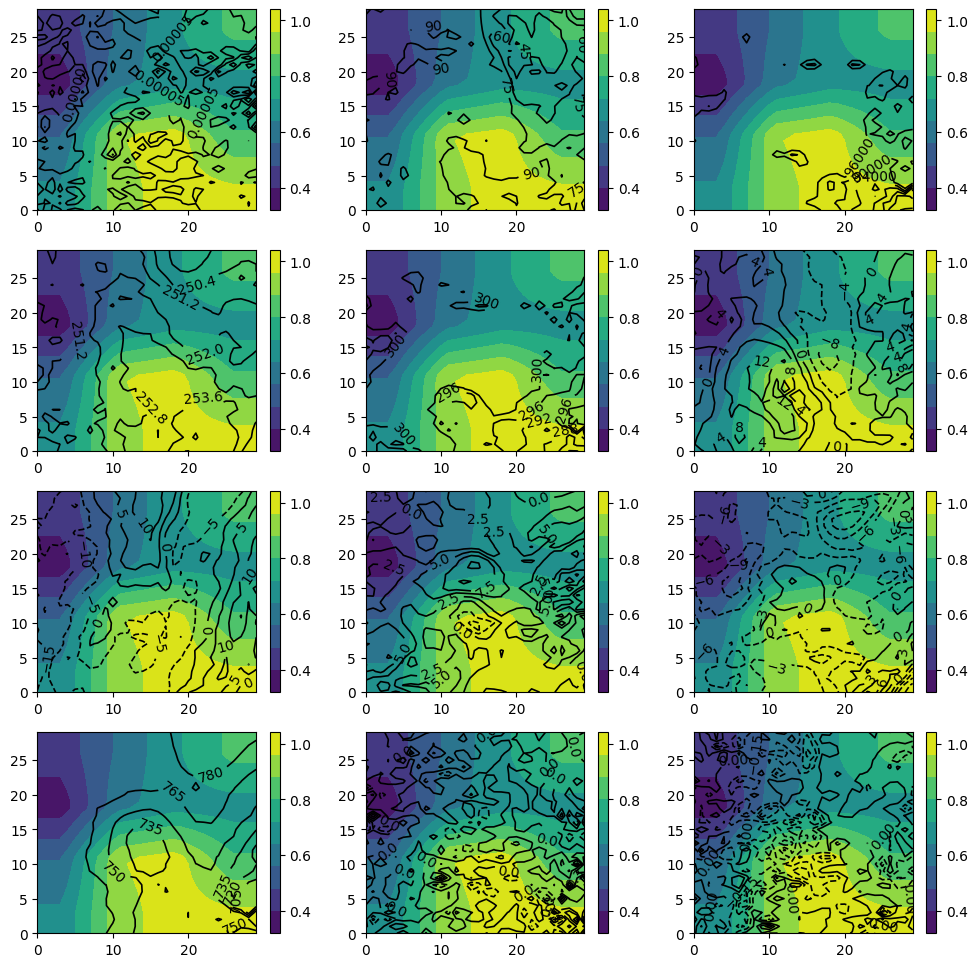

In [64]:
#
# superimposed heatmap on top of all channels
#
plt.figure(figsize=(12,12))
for i in range(12):
    ax = plt.subplot(4,3,i+1)
    x=plt.contourf(b) 
    plt.colorbar(x,ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
    y=plt.contour(dim_data[:,:,i],colors='k', linewidths=1.2)
    plt.clabel(y, inline=1, fontsize=10)
    #plt.axis("off")    